In [615]:
# referrence:  https://keras.io/examples/timeseries/timeseries_weather_forecasting/
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import missingno as msno
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [616]:
DATA_DIR = '../../data/data_daily_with_aqi.csv'
raw_df = pd.read_csv(DATA_DIR)
test = raw_df[raw_df.date>'2022-01-01']
train = raw_df[raw_df.date<'2022-01-01']
raw_df = train

In [617]:
raw_df.type.unique()

array(['O3_24h', 'NO2_24h', 'SO2_24h', 'PM2.5_24h', 'AQI'], dtype=object)

In [618]:
df = raw_df[raw_df['type']=='AQI'].drop('type',axis=1)


In [619]:
df = df.drop(['date','hour'],axis=1)

In [620]:
for i in range(1,6):
    df['lag'+str(i)] = df['北京'].shift(i)

In [621]:
df = df.fillna(method='ffill')

In [622]:
df = df.dropna(how='any')

In [623]:
df = df.loc[:,['北京','lag1','lag2','lag3','lag4','lag5']]

In [624]:
step = 1
past = 200
future = 15
learning_rate = 1e-4
batch_size = 256
epochs = 500
sequence_length = 1

# df = df.apply(np.log).diff(1)


df['label'] = df['北京'].shift(-future)
df =  df.fillna(method='ffill').dropna(how='any',axis=0)
df = df.reset_index(drop=True)

In [625]:

split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))

In [626]:
features = df.reset_index(drop=True)
# features = normalize(features.values, train_split)
# features = pd.DataFrame(features)
# features.head()
train_data = features.iloc[: train_split,:]
val_data = features.iloc[train_split-sequence_length:,:]

In [627]:
x_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
x_val = val_data.iloc[:,:-1].values
y_val = val_data.iloc[:,-1].values
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_val = x_scaler.transform(x_val)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_val = y_scaler.transform(y_val.reshape(-1,1))


In [628]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [629]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (256, 1, 6)
Target shape: (256, 1)


In [630]:
# inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# outputs = keras.layers.Dense(32)(inputs)
# outputs2 = keras.layers.Dense(16)(outputs)
# outputs3 = keras.layers.Dense(1)(outputs2)
# model = keras.Model(inputs=inputs, outputs=outputs3)
model = keras.models.Sequential([
    keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])),
    keras.layers.Dense(32),
    keras.layers.Dense(16),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 1, 32)             224       
                                                                 
 dense_77 (Dense)            (None, 1, 16)             528       
                                                                 
 dense_78 (Dense)            (None, 1, 1)              17        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [631]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=15, verbose=1, mode="auto", baseline=None, restore_best_weights=True)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, 
               modelckpt_callback,
               ],
)

Epoch 1/500
1/8 [==>...........................] - ETA: 1s - loss: 3.6143

2022-05-22 10:08:31.294304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 2.2034
Epoch 1: val_loss improved from inf to 1.39984, saving model to model_checkpoint.h5
8/8 [==============================] - 1s 48ms/step - loss: 2.2034 - val_loss: 1.3998
Epoch 2/500
1/8 [==>...........................] - ETA: 0s - loss: 3.4284

2022-05-22 10:08:31.629478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/8 [=========================>....] - ETA: 0s - loss: 2.2202
Epoch 2: val_loss improved from 1.39984 to 1.32295, saving model to model_checkpoint.h5
8/8 [==============================] - 0s 30ms/step - loss: 2.0997 - val_loss: 1.3230
Epoch 3/500
5/8 [=================>............] - ETA: 0s - loss: 2.4780
Epoch 3: val_loss improved from 1.32295 to 1.24990, saving model to model_checkpoint.h5
8/8 [==============================] - 0s 26ms/step - loss: 2.0049 - val_loss: 1.2499
Epoch 4/500
4/8 [==============>...............] - ETA: 0s - loss: 2.4643
Epoch 4: val_loss improved from 1.24990 to 1.18125, saving model to model_checkpoint.h5
8/8 [==============================] - 0s 27ms/step - loss: 1.9166 - val_loss: 1.1812
Epoch 5/500
4/8 [==============>...............] - ETA: 0s - loss: 2.3598
Epoch 5: val_loss improved from 1.18125 to 1.11718, saving model to model_checkpoint.h5
8/8 [==============================] - 0s 26ms/step - loss: 1.8346 - val_loss: 1.1172
Epoch 6/500
5/8 [===

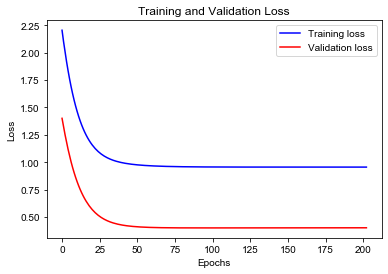

In [632]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [633]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



4/4 [==============================] - 0s 16ms/step


2022-05-22 10:09:13.582320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'r2_score:-0.1700')

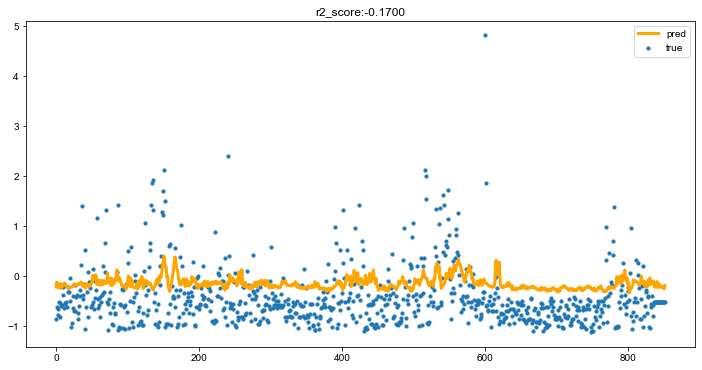

In [634]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_val)
y_pred = pred.flatten()
y_true = y_val.flatten()[-len(y_pred):]
plt.figure(figsize=(12, 6))
plt.plot(y_pred,label = 'pred',color = 'orange',linewidth=3)
plt.scatter(list(range(len(y_true))),y_true,label='true',s=10)
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))


In [635]:
model.save('./models/lstm_128_dense_1.h5')

8/8 [==============================] - 0s 12ms/step


Text(0.5, 1.0, 'r2_score:0.0453')

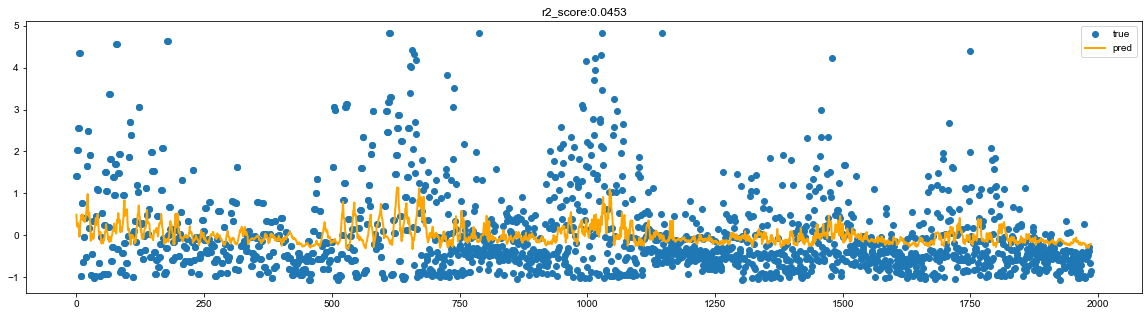

In [636]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_train)
y_pred = pred.flatten()
y_true = y_train.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))

plt.scatter(list(range(len(y_true))),y_true,label='true')
plt.plot(y_pred,label = 'pred',color='orange',linewidth=2)
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))
